In [1]:
# for running inference on the TF-Hub module.
import tensorflow_hub as hub
import tensorflow as tf 
print(tf.__version__)

# for downloading the image
from six.moves.urllib.request import urlopen
from six import BytesIO # I for input & O for output, BytesIO is an in-memory buffer which means chunk memory without writing content to real memory, as it takes bytes of data for images input into binay data
import matplotlib.pyplot as plt
import tempfile
import requests


# for drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# for measuring the inference time.
import time
print("The following GPU devices are available: %s " % tf.test.gpu_device_name())

2.5.0
The following GPU devices are available: /device:GPU:0 


In [2]:
def display_image(image):
  fig = plt.figure(figsize=(20,15))
  plt.grid(False)
  plt.imshow(image)

def download_and_resize_image(url, new_width=256, new_height=256,
                                display=False):
  _,filename = tempfile.mkstemp(suffix=".jpg") # tempfile is temporaryfile loads input and mkstemp uses to make extension suffix 
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)#use bytesio conveting raw data of images or ascii form into numeric binary data
  pil_image = Image.open(image_data)# Image is function of pillow to open image
  pil_image = ImageOps.fit(pil_image, (new_width,new_height), Image.ANTIALIAS) # ImageOps is an image operations on an image & Antialis is used for backward image compatability filtering which means due to digital pixels conflict the shapes of the boundary edges/outlines are curved of any image or structure shapes. so to fix it antialias used.
  pil_image_rgb = pil_image.convert("RGB") # convert to standard rgb format
  pil_image_rgb.save(filename, format='JPEG', quality=90)
  print("image downloaded to %s. " % filename)
  if display:
    display_image(pil_image) 
  return filename

def draw_bouning_box_on_image(image,
                              ymin,
                              xmin,
                              ymax,
                              xmax,
                              color,
                              font,
                              thickness=4,
                              display_str_list=()):
  """Add a bounding box to an image"""
  draw = ImageDraw.Draw(image) 
  im_width, im_height = image.size
  (left,right,top,bottom) = (xmin * im_width, xmax * im_width,
                             ymin * im_height, ymax * im_height)
  draw.line([(left,top), (left,bottom), (right,bottom), (right,top),
             (left,top)], # Giving  closed loop of points as list to draw.line function
            width = thickness,
            fill = color)
  
   # if the total height of the display strings added to the top of the bounding
   # box exceeds the top of the image,stack the strings below the bounding box
   # instead of above.

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

   # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([ (left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill = color)
    draw.text( (left + margin, text_bottom - text_height - margin),
              display_str,
              fill = 'black',
              font = font) 
    text_bottom = text_height -2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_scored=0.1):
  """Overlay labelled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_scored:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bouning_box_on_image(image_pil,
                                ymin,xmin,ymax,xmax,
                                color,font,
                                display_str_list=[display_str]) 
      np.copyto(image, np.array(image_pil))
  return image   

Apply module

load a public image from open images v4, save locally, and display.

image downloaded to /tmp/tmp0arpfma8.jpg. 


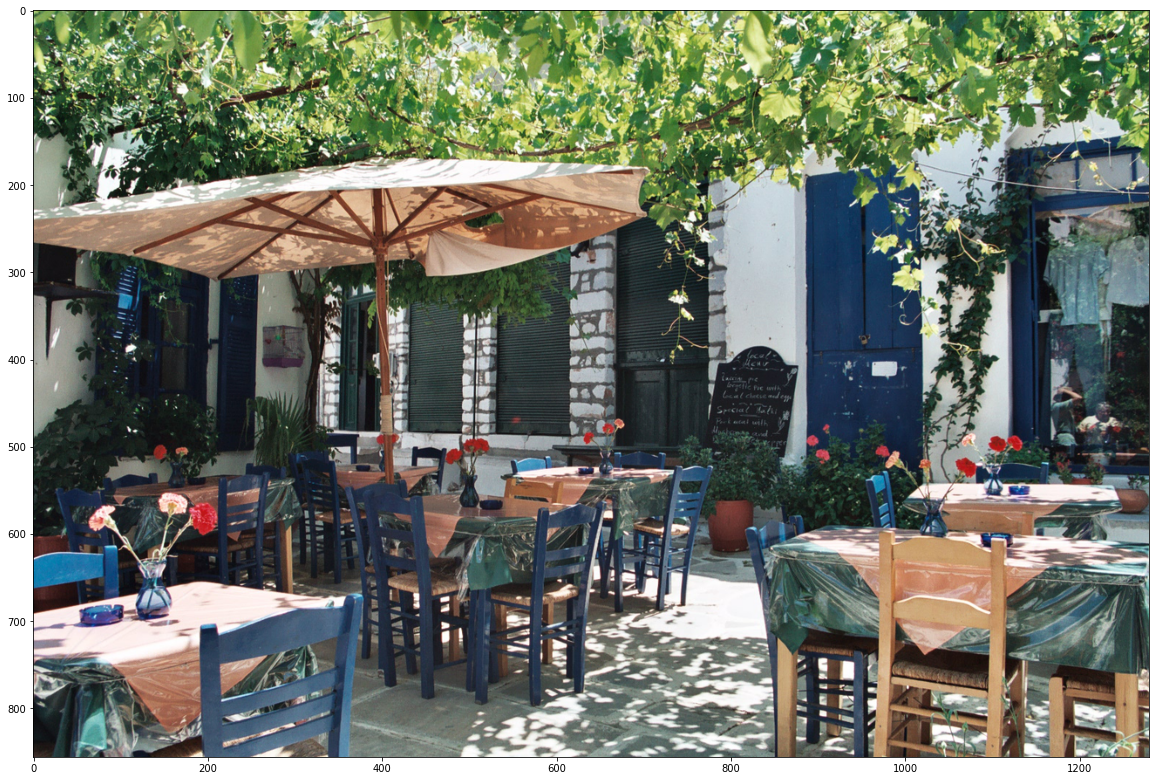

In [3]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Pick an object detection module and apply on the downloaded image. Modules:

  - FasterRCNN+InceptionResNet V2: high acccuracy
  - ssd+mobilenet V2:small and fast











In [4]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default'] # hub is a tensorflow repository where all the pre-trained models are built and defined.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img


In [6]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img = tf.image.convert_image_dtype(img, tf.float32) [tf.newaxis,...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  
  print("found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result['detection_boxes'],
      result['detection_class_entities'], result["detection_scores"])
  
  display_image(image_with_boxes)

found 100 objects.
Inference time:  30.455042600631714


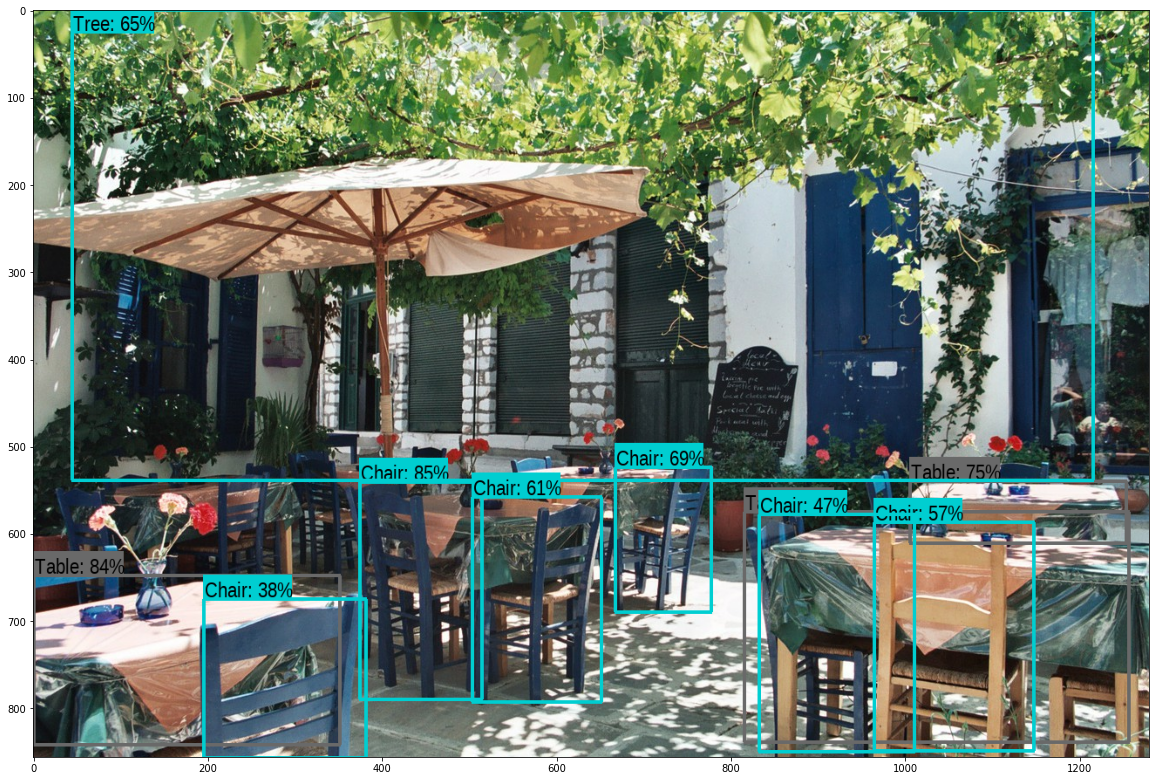

In [7]:
run_detector(detector,downloaded_image_path)

In [8]:
image_urls = ["https://upload.wikimedia.org/wikipedia/commons/6/6f/The_Coleoptera_of_the_British_islands_BHL33254295.jpg",
              "https://upload.wikimedia.org/wikipedia/commons/1/1c/The_smaller_British_birds_%288053841028%29.jpg",
              "https://upload.wikimedia.org/wikipedia/commons/a/a8/Red-webbed_tree_%28or_Canal_Zone%29_frog_%28Hypsiboas_rufitelus%29.jpg",
              "https://upload.wikimedia.org/wikipedia/commons/e/e2/Insects_collage.jpg"]
def detect_img(image_urls):
  start_time = time.time()
  image_path = download_and_resize_image(image_urls, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:", end_time-start_time)



image downloaded to /tmp/tmp4426x1l7.jpg. 
found 100 objects.
Inference time:  2.907660722732544
Inference time: 3.242990016937256
image downloaded to /tmp/tmpdpket2yp.jpg. 
found 100 objects.
Inference time:  1.1233928203582764
Inference time: 1.4265689849853516
image downloaded to /tmp/tmp9y9485pn.jpg. 
found 100 objects.
Inference time:  1.1408205032348633
Inference time: 1.5453815460205078
image downloaded to /tmp/tmpitimidpj.jpg. 
found 100 objects.
Inference time:  1.1271038055419922
Inference time: 1.6544599533081055


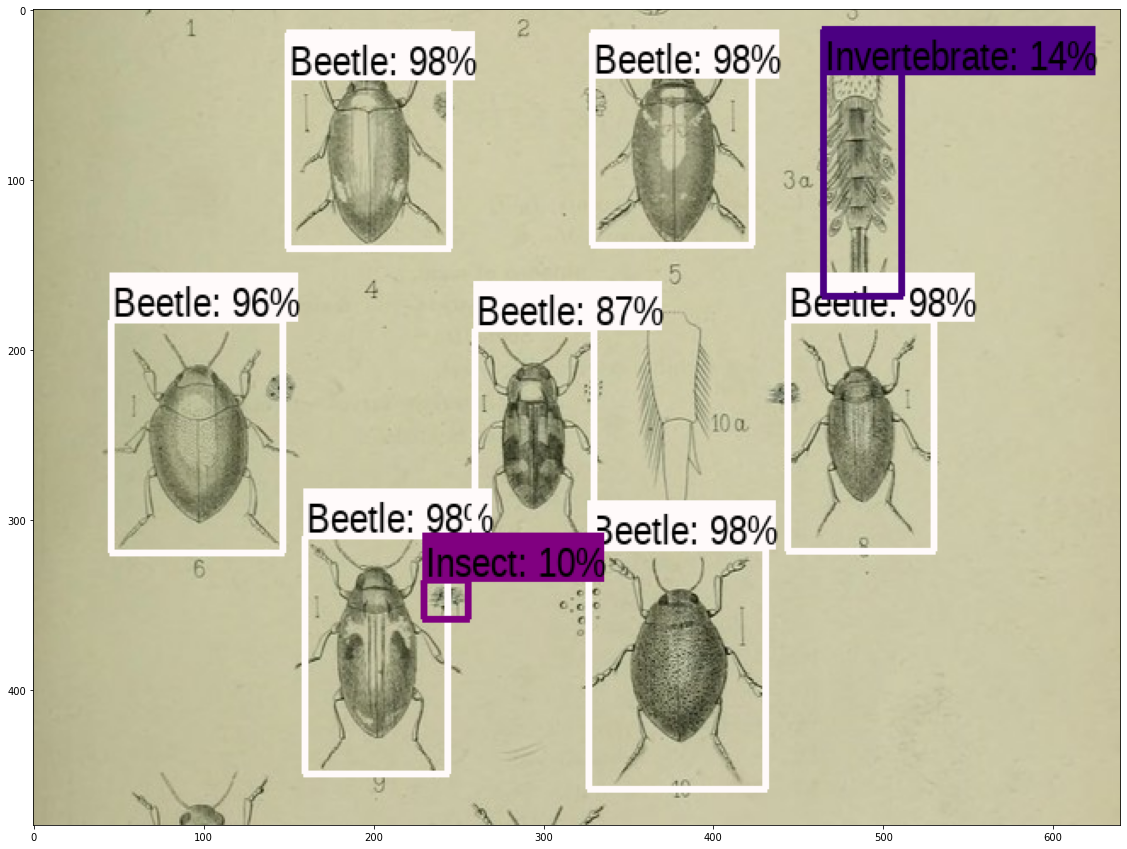

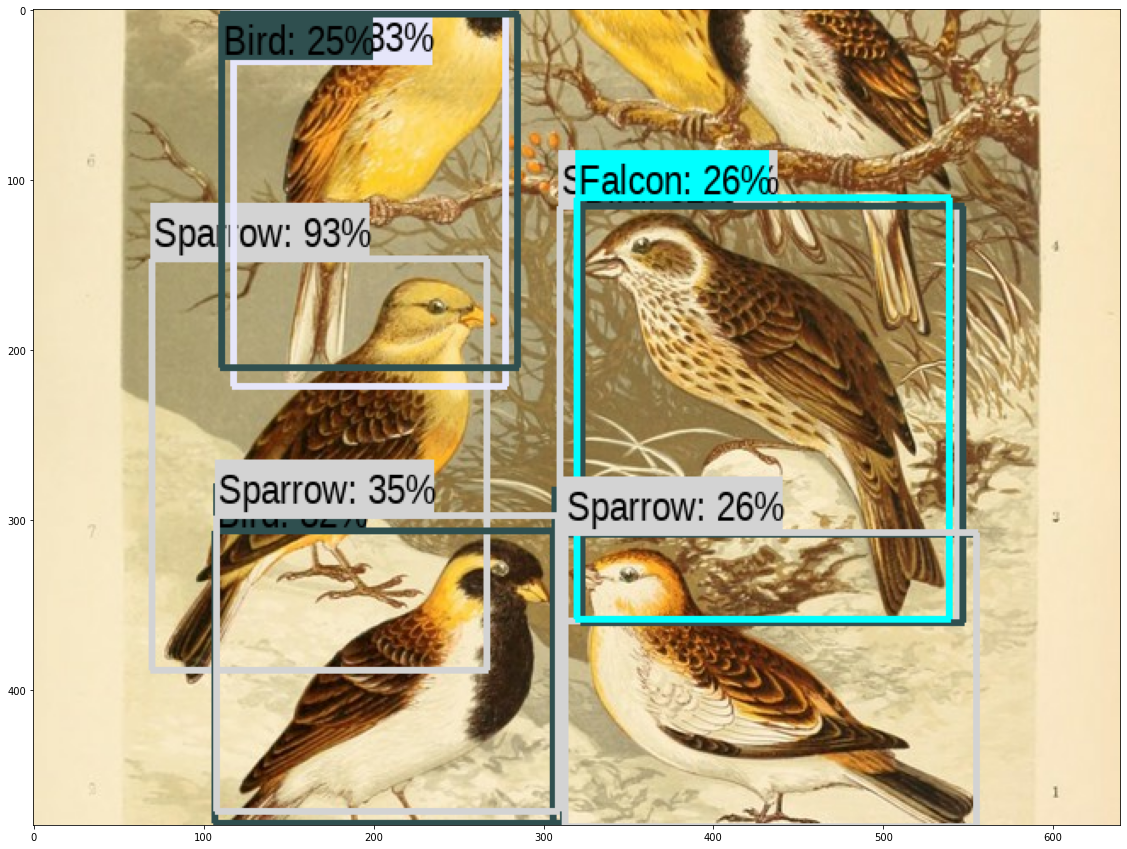

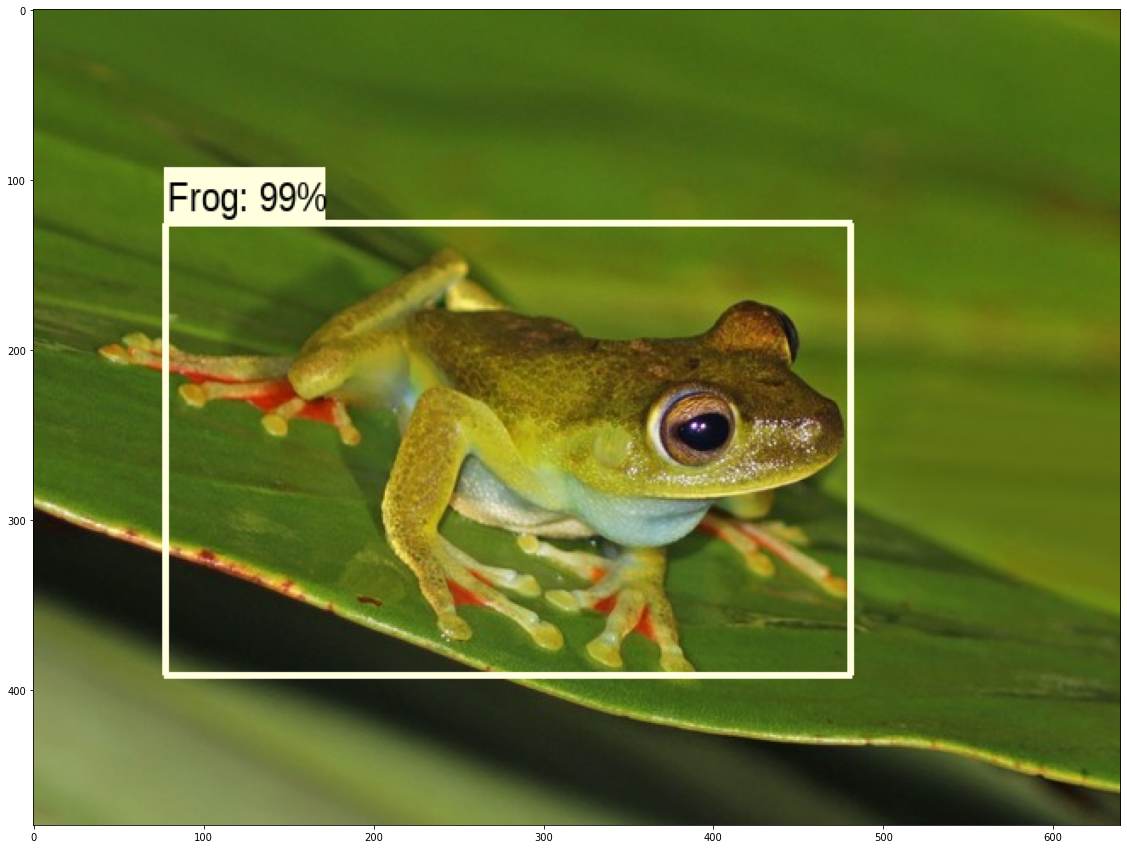

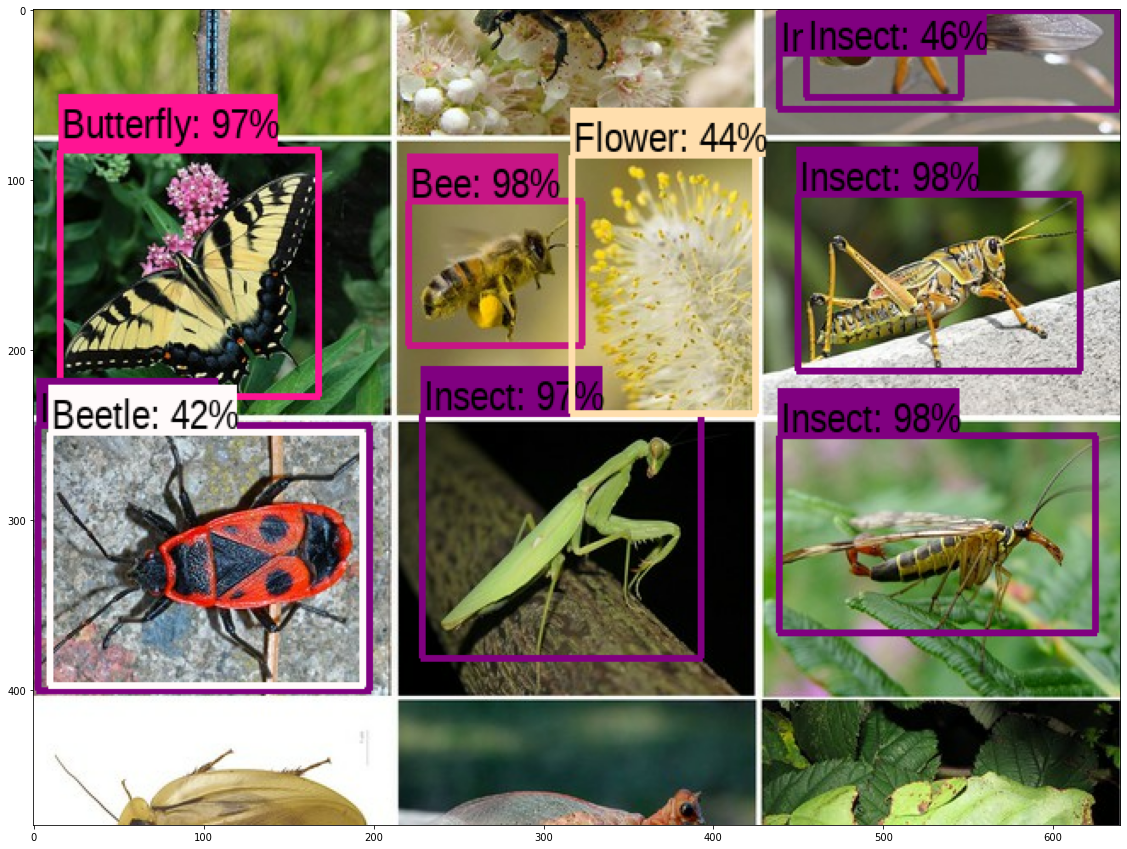

In [9]:
for i in range(len(image_urls)):
  detect_img(image_urls[i])